# DFUC24 Baseline: GroundingDINO fine-tuning for ulcer object detection on DFUC22 dataset

The author of this notebook is Benjamin Bracke ([Github](https://github.com/B-Bracke)).

## Imports

In [2]:
import os
import glob
import copy
import json
import time
from tqdm import tqdm
import numpy as np
import pandas as pd
import cv2
import albumentations as A
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch import autocast
from torch.cuda.amp import GradScaler

from torchmetrics import MetricCollection
from torchmetrics.aggregation import MeanMetric
from torchmetrics.classification import BinaryJaccardIndex, BinaryF1Score, BinaryRecall, BinaryPrecision, BinaryConfusionMatrix
from torchmetrics.detection.iou import IntersectionOverUnion
from torchmetrics.detection.mean_ap import MeanAveragePrecision

#os.environ["CUDA_LAUNCH_BLOCKING"] = "1"
os.environ["TOKENIZERS_PARALLELISM"] = "1"

## Defining important path variables

In [ ]:
ROOT_DIR = os.path.abspath(os.getcwd()) # current path of the notebook
DATA_DIR = "/raid/DFUC24/datasets/dfuc2022/sep/" # path to the dataset root directory
IMAGE_FILES = os.path.join(DATA_DIR, "images/") # path to the images
ANNOTATION_FILES = os.path.join(DATA_DIR, "labels/") # path to the ground truth annotations

print("Directories:")
print("Root directory:", ROOT_DIR)
print("Image files in directory:", IMAGE_FILES)
print("Ground Truth annotations files in directory:", ANNOTATION_FILES)

## Data set

### Define the dataset class, pre-processing and augmentation pipelines and helper functions

In [ ]:
class DFUC22_ODDataset(Dataset):
    def __init__(self, image_files: list, annotations_file: str, transfom=None):
        self.image_files = image_files
        self.annotations_file = annotations_file
        self.transform = transfom

        # Load COCO annotations
        with open(annotations_file, 'r') as f:
            self.coco_annotations = json.load(f)

        self.image_id_to_annotations = self._map_image_id_to_annotations()

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, index):
        img_file = self.image_files[index]
        
        # Load image using OpenCV
        img = cv2.cvtColor(cv2.imread(img_file, cv2.IMREAD_COLOR), cv2.COLOR_BGR2RGB)

        # Get bbox annotations for the image
        img_id = self._get_image_id(img_file)
        annotations = self.image_id_to_annotations.get(img_id, [])
        bboxes = [ann['bbox'] for ann in annotations]
        labels = [ann['category_id'] for ann in annotations]
        area = [ann['area'] for ann in annotations]

        # Apply albumentations augmentations if any
        if self.transform:
            transformed = self.transform(image=img, bboxes=bboxes, labels=labels)
            img = transformed['image']
            bboxes = transformed['bboxes']
            labels = transformed['labels']

        img = np.rollaxis(img, -1, 0)
        img = torch.from_numpy(img).to(torch.uint8)

        # Convert bbox format from [x, y, width, height] to (center_x, center_y, w, h) and normalize bbox format by image size
        bboxes = [[x + w / 2, y + h / 2, w, h] for x, y, w, h in bboxes]
        bboxes = [[x / img.shape[2], y / img.shape[1], w / img.shape[2], h / img.shape[1]] for x, y, w, h in bboxes]
        
        bboxes = torch.tensor(bboxes, dtype=torch.float32)
        labels = torch.tensor(labels, dtype=torch.int64)
        area = torch.tensor(area, dtype=torch.float32)

        return img, {'boxes': bboxes, 'class_labels': labels, 'area':area}

    def _map_image_id_to_annotations(self):
        image_id_to_annotations = {}
        for ann in self.coco_annotations['annotations']:
            image_id = ann['image_id']
            image_id = [int(img["file_name"].split(".")[0]) for img in self.coco_annotations['images'] if img["id"]==image_id][0]
            
            if image_id not in image_id_to_annotations:
                image_id_to_annotations[image_id] = []
            image_id_to_annotations[image_id].append(ann)
        return image_id_to_annotations

    def _get_image_id(self, img_file):
        # Extract the image id from the image file name
        # This assumes the image file names are structured to allow this extraction.
        # Adjust this method as per your file naming convention.
        img_id = int(img_file.split('/')[-1].split('.')[0])
        return img_id

def collate_fn(batch):
    images, targets = [], []
    
    for b in batch:
        images.append(b[0])
        targets.append(b[1])

    images = torch.stack(images)
    return images, targets


def move_to_device(batch, device):
    """
    Move a batch of tensors (list of dictionaries) to the specified device.
    
    Args:
    - batch (list of dict): A list of dictionaries containing tensors.
    - device (torch.device): The target device to move the tensors to.
    
    Returns:
    - list of dict: A list of dictionaries with tensors moved to the specified device.
    """
    return [{key: value.to(device) if torch.is_tensor(value) else value for key, value in sample.items()} for sample in batch]


def cxcywh2xyxy(boxes):
    """
    Convert bounding boxes from cx, cy, w, h format to x1, y1, x2, y2 format

    Args:
    boxes (list of dict): List of dictionaries, each containing a key "boxes" 
                          with a tensor value in the format [[cx, cy, w, h]].
    """
    converted_boxes = copy.deepcopy(boxes)
    for box_dict in converted_boxes:
        boxes_tensor = box_dict['boxes']
        x1 = boxes_tensor[:, 0] - boxes_tensor[:, 2] / 2  # x1
        y1 = boxes_tensor[:, 1] - boxes_tensor[:, 3] / 2  # y1
        x2 = boxes_tensor[:, 0] + boxes_tensor[:, 2] / 2  # x2
        y2 = boxes_tensor[:, 1] + boxes_tensor[:, 3] / 2  # y2
        box_dict['boxes'] = torch.stack([x1, y1, x2, y2], dim=1)
    return converted_boxes

def class_label2label(boxes):
    """
    Rename the key 'class_labels' to 'labels' in each dictionary

    Args:
    boxes (list of dict): List of dictionaries, each containing a key "class_labels".
    """
    converted_boxes = copy.deepcopy(boxes)
    for box_dict in converted_boxes:
        box_dict['labels'] = box_dict.pop('class_labels')
    return converted_boxes

def convert_bbox_format2sam_prompts(data, image_width, image_height):
    result = []
    max_boxes = 0
    
    # First pass to find the maximum number of boxes
    for item in data:
        boxes_tensor = item['boxes']
        num_boxes = boxes_tensor.shape[0] if boxes_tensor.numel() > 0 else 0
        max_boxes = max(max_boxes, num_boxes)
    
    # Second pass to convert and pad boxes
    for item in data:
        boxes_tensor = item['boxes']
        if boxes_tensor.numel() == 0:
            boxes_list = []
        else:
            # Convert from image size normalized xyxy to non-normalized xyxy format
            boxes = boxes_tensor.cpu().tolist()
            converted_boxes = []
            for box in boxes:
                x1 = box[0] * image_width
                y1 = box[1] * image_height
                x2 = box[2] * image_width
                y2 = box[3] * image_height
                converted_boxes.append([x1, y1, x2, y2])
            
            boxes_list = converted_boxes
        
        # Pad the boxes_list if it has fewer than max_boxes elements
        while len(boxes_list) < max_boxes:
            boxes_list.append([0, 0, 0, 0])

        result.append(boxes_list)
    
    return result


# albumentation augmentation pipeline for the training images 
pre_transform = A.Compose([
        A.Flip(p=0.5),
        A.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1, p=0.5),
    ], bbox_params=A.BboxParams(format='coco', label_fields=['labels']))


id2label = {
    0: "background.",
    1: "wound."}
print(f"label classes {id2label}")

### Initializing the test data set and data loader

In [ ]:
# load image filenames from disk
train_image_files = sorted(glob.glob(IMAGE_FILES + '/train/*.png'))
train_annotation_file = ANNOTATION_FILES + '/instances_train.json'

valid_image_files = sorted(glob.glob(IMAGE_FILES + '/valid/*.png'))
valid_annotation_file = ANNOTATION_FILES + '/instances_val.json'

# create train and validation datasets
train_dataset = DFUC22_ODDataset(train_image_files, train_annotation_file, pre_transform)
valid_dataset = DFUC22_ODDataset(valid_image_files, valid_annotation_file, None)
print(f'Found {len(train_dataset)} images for training')
print(f'Found {len(valid_dataset)} images for validation')

# create train and validation data loaders
BATCH_SIZE = 8 # batch size for single forward pass 
ACC_STEPS = 4 # steps for gradient accumulation
TEXT_PROMPT = ["wound ."] # text prompt for the model

# train data loader
train_loader = DataLoader(dataset=train_dataset,
                          collate_fn=collate_fn,
                          shuffle=True,
                          drop_last=True,
                          persistent_workers=True,
                          batch_size=BATCH_SIZE, 
                          num_workers=4, # for multi-threading 
                          pin_memory=True)

# validation data loader
valid_loader = DataLoader(dataset=valid_dataset,
                          collate_fn=collate_fn,
                          shuffle=False, 
                          batch_size=BATCH_SIZE, 
                          num_workers=4, # for multi-threading 
                          pin_memory=True,
                          persistent_workers=True
)

### Display some images

In [6]:
dataiter = iter(train_loader) # get iterator of valid data loader 

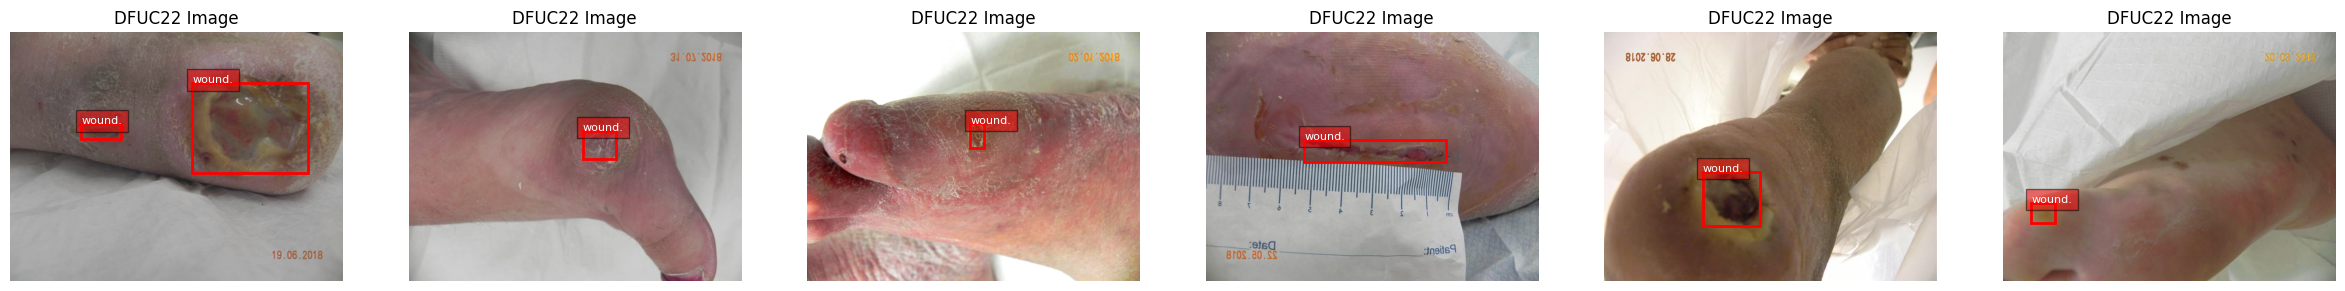

In [8]:
def show_subset(images, targets, n):
    fig, ax = plt.subplots(1, n, figsize=(n*5, 5))
    for i in range(n):
        img = images[i].numpy()
        img = np.rollaxis(img, 0, 3) # np.rollaxis to swap channel axes to channels last
        bboxes = targets[i]['boxes'].numpy()
        labels = targets[i]['class_labels'].numpy()

        ax[i].imshow(img, vmin=0, vmax=1, cmap='gray') 
        
        for bbox, label in zip(bboxes, labels):          
            x_min, y_min, w, h = bbox[0] - bbox[2] / 2, bbox[1] - bbox[3] / 2, bbox[2], bbox[3] # convert cx, cy, w, h, to x, y, w, h
            x_min, y_min, w, h = x_min * img.shape[1], y_min * img.shape[0], w * img.shape[1], h * img.shape[0] # denormalize bbox format
            rect = plt.Rectangle((x_min, y_min), w, h, linewidth=2, edgecolor='red', facecolor='none')
            ax[i].add_patch(rect)
            ax[i].text(x_min, y_min, id2label[label], color='white', fontsize=8, bbox=dict(facecolor='red', alpha=0.5))
        
        ax[i].set_title('DFUC22 Image')
        ax[i].axis('off')

    plt.show()

images, targets = next(dataiter) # get a random batch of train_loader iterator
show_subset(images, targets, n=6) # show images, masks subset of size n of batch

## Defining the model

In [9]:
device = ("cuda" if torch.cuda.is_available() else "cpu") 
print(f"device: {device}")

device: cuda


### GroundedDINO Model

In [ ]:
from transformers import GroundingDinoProcessor, GroundingDinoForObjectDetection

MODEL_DIR = "./models/groundingdino_finetune/" # path to save the model checkpoints, logs, etc.
print("model_dir: ", os.path.realpath(MODEL_DIR))
os.makedirs(MODEL_DIR, exist_ok=True)

# load grounding dino model for object detection
gd_model_id = "IDEA-Research/grounding-dino-base"
gd_model = GroundingDinoForObjectDetection.from_pretrained(gd_model_id, return_dict=True).to(device)
gd_processor = GroundingDinoProcessor.from_pretrained(gd_model_id)


# load checkpoint if available
GD_CHECKPOINTS = None # "./models/groundingdino_finetune/model_epoch53.pth"
if GD_CHECKPOINTS:
    gd_model.load_state_dict(torch.load(f'{GD_CHECKPOINTS}', map_location='cpu'))
    torch.cuda.empty_cache()
    print(f"use model checkpoints: {GD_CHECKPOINTS}")

# Freeze the parameters of the GroundedDino image and text backbones as we are only fine-tuning the detection head
for name, param in gd_model.named_parameters():
    if name.startswith("model.text_backbone") or name.startswith("model.backbone"):
        param.requires_grad = False

print(gd_model)

## Train the model

### Define the optimizer, gradient scaler and loss function and metrics

In [11]:
scaler = GradScaler() # gradient scaler for mixed precision training

# optimizer 
LEARN_RATE = 2.5e-05
optimizer = torch.optim.AdamW(filter(lambda param: param.requires_grad, gd_model.parameters()), lr=LEARN_RATE, weight_decay=0.01)

# metrics
loss_metric = MeanMetric().to(device)
metrics = MetricCollection({
    "IoU": IntersectionOverUnion(box_format='xyxy'),
    'mAP': MeanAveragePrecision(box_format='xyxy', iou_type='bbox')
}).to(device)

# logs for training and validation
logs = {'loss': [], 'IoU': [], 'mAP': [], 'mAP50': [], 'mAP75': [], 'val_loss': [], 'val_IoU': [], 'val_mAP': [], 'val_mAP50': [], 'val_mAP75': []}

### Training loop

In [ ]:
NUM_EPOCHS = 30 # number of epochs to train the model

start_training = time.perf_counter() # start time of trainig
for epoch in range(NUM_EPOCHS):
    epoch_start = time.perf_counter() # start time of epoch
    print(f'Epoch {epoch+1}/{NUM_EPOCHS}')
    
    ############################## train phase ####################################
    gd_model.train() 

    # zero the parameter gradients
    optimizer.zero_grad(set_to_none=True)
    torch.cuda.empty_cache()
    
    # iterate over training batches
    for batch_idx, (images, targets) in enumerate(train_loader):
        batch_size = images.shape[0]
        inputs = gd_processor(images=images, text=TEXT_PROMPT * batch_size, return_tensors="pt")
        inputs = inputs.to(device)
        targets = move_to_device(targets, device)
        
        # forward groundeddino model with mixed precision and gradient accumulation
        with autocast(device_type='cuda', dtype=torch.float16):
            outputs = gd_model(**inputs, labels=targets, return_dict=True)
            # loss calculation with bbox loss and giou loss and coefficient as in the original paper
            loss = (outputs["loss_dict"]["loss_bbox"] * gd_model.config.bbox_loss_coefficient +
                    outputs["loss_dict"]["loss_giou"] * gd_model.config.giou_loss_coefficient
                   ) / ACC_STEPS

        # backpropagate the loss
        scaler.scale(loss).backward()
    
        # update the model weights after ACC_STEPS gradient accumulation steps else accumulate gradients 
        if (batch_idx + 1) % ACC_STEPS == 0:
            scaler.unscale_(optimizer)
            torch.nn.utils.clip_grad_norm_(gd_model.parameters(), 0.1)  # optimize with gradient clipping
            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad(set_to_none=True)        
        

        # Compute metrics for the batch
        loss_metric.update((loss * ACC_STEPS).detach())
        preds = gd_processor.image_processor.post_process_object_detection(outputs, threshold=0.3) # bbox output format is xyxy
        conv_targets = cxcywh2xyxy(targets)
        conv_targets = class_label2label(conv_targets)
        metrics.update(preds, conv_targets)


    # compute final epoch metrics and reset for validation phase
    epoch_loss = loss_metric.compute()
    epoch_metrics = metrics.compute()
    loss_metric.reset()
    metrics.reset()
    
    # Append metric results to logs
    logs['loss'].append(epoch_loss.cpu().item())
    logs['mAP'].append(epoch_metrics['map'].cpu().item())
    logs['mAP50'].append(epoch_metrics['map_50'].cpu().item())
    logs['mAP75'].append(epoch_metrics['map_75'].cpu().item())
    logs['IoU'].append(epoch_metrics['iou'].cpu().item())
    print(f"loss: {logs['loss'][epoch]:.5f}, mAP: {logs['mAP'][epoch]:.5f}, mAP50: {logs['mAP50'][epoch]:.5f}, mAP75: {logs['mAP75'][epoch]:.5f}, IoU: {logs['IoU'][epoch]:.5f}", end=' || ')

    # zero the parameter gradients
    optimizer.zero_grad(set_to_none=True)
    torch.cuda.empty_cache()

    ############################## valid phase ####################################
    with torch.no_grad():
        gd_model.eval()
    
        # iterate over validation batches
        for (images, targets) in valid_loader:
            batch_size = images.shape[0]
            inputs = gd_processor(images=images, text=TEXT_PROMPT * batch_size, return_tensors="pt")
            inputs = inputs.to(device)
            targets = move_to_device(targets, device)
            
            # forward with mixed precision and no gradient collection
            with autocast(device_type='cuda', dtype=torch.float16):
                outputs = gd_model(**inputs, labels=targets, return_dict=True)
                loss = (outputs["loss_dict"]["loss_bbox"] * gd_model.config.bbox_loss_coefficient +
                    outputs["loss_dict"]["loss_giou"] * gd_model.config.giou_loss_coefficient
                   )
                
            # Compute metrics for batch
            loss_metric.update((loss).detach())
            preds = gd_processor.image_processor.post_process_object_detection(outputs, threshold=0.3) # bbox output format is xyxy
            conv_targets = cxcywh2xyxy(targets)
            conv_targets = class_label2label(conv_targets)
            metrics.update(preds, conv_targets)
    
        # compute final metrics for validation epoch and reset metrics
        epoch_loss = loss_metric.compute()
        epoch_metrics = metrics.compute()
        loss_metric.reset()
        metrics.reset()
    
        # Append metric results to logs
        logs['val_loss'].append(epoch_loss.cpu().item())
        logs['val_mAP'].append(epoch_metrics['map'].cpu().item())
        logs['val_mAP50'].append(epoch_metrics['map_50'].cpu().item())
        logs['val_mAP75'].append(epoch_metrics['map_75'].cpu().item())
        logs['val_IoU'].append(epoch_metrics['iou'].cpu().item())
        print(f"val_loss: {logs['val_loss'][epoch]:.5f}, val_mAP: {logs['val_mAP'][epoch]:.5f}, val_mAP50: {logs['val_mAP50'][epoch]:.5f}, val_mAP75: {logs['val_mAP75'][epoch]:.5f}, val_IoU: {logs['val_IoU'][epoch]:.5f}", end=' || ')
            
    # save logs as csv
    logs_df = pd.DataFrame(logs)
    logs_df.to_csv(f'{MODEL_DIR}train_history.csv', index_label='epoch', sep=',', encoding='utf-8')

    #save trained model for each epoch
    torch.save(gd_model.state_dict(), f'{MODEL_DIR}model_epoch{epoch}.pth')
    torch.save(optimizer.state_dict(), f'{MODEL_DIR}optimizer_epoch{epoch}.pth')
    torch.save(scaler.state_dict(), f'{MODEL_DIR}mp_scaler_epoch{epoch}.pth')
    
    # end time of epoch
    epoch_end = time.perf_counter()
    print(f"epoch runtime: {epoch_end-epoch_start:5.3f} sec.")
    torch.cuda.empty_cache()

#save final trained model
torch.save(gd_model.state_dict(), f'{MODEL_DIR}model_epoch{epoch}.pth')
torch.save(optimizer.state_dict(), f'{MODEL_DIR}optimizer_epoch{epoch}.pth')
torch.save(scaler.state_dict(), f'{MODEL_DIR}mp_scaler_epoch{epoch}.pth')

# end time of trainig
end_training = time.perf_counter()
print(f'Training succeeded in {(end_training - start_training):5.3f}s')

### Visualization of the training process

In [ ]:
metrics = ['loss', 'mAP', 'mAP50', 'mAP75', 'IoU']
fig, ax = plt.subplots(2, 3, figsize=(20, 10))

for i, metric in enumerate(metrics):
    row, col = divmod(i, 3)
    ax[row, col].plot(logs[metric], label='train')
    ax[row, col].plot(logs[f'val_{metric}'], label='valid')
    ax[row, col].set_title(f'Model {metric}')
    ax[row, col].set_ylim(0, 1)
    ax[row, col].set_xlim(0, NUM_EPOCHS-1)
    ax[row, col].set_ylabel(metric)
    ax[row, col].set_xlabel('Epoch')
    ax[row, col].legend(loc='best')
    
# Hide any unused subplots
for j in range(len(metrics), 6):
    row, col = divmod(j, 3)
    ax[row, col].set_visible(False)
    
fig.tight_layout()
fig.savefig(f'{MODEL_DIR}/training_history.png', dpi=100, format="png")
plt.show()

## Final Validation of the trained model

In [ ]:
gd_metrics = MetricCollection({
    "iou": IntersectionOverUnion(box_format='xyxy'),
    'map': MeanAveragePrecision(box_format='xyxy', iou_type='bbox')
})

with torch.no_grad():
    gd_model.eval()

    for (images, targets) in tqdm(valid_loader):
        prompts = TEXT_PROMPT * images.shape[0]

        # forward GroundedDINO to get ulcer detection predictions
        gd_inputs = gd_processor(images=images, text=prompts, return_tensors="pt").to(device)
        with autocast(device_type='cuda', dtype=torch.float16):
            gd_outputs = gd_model(**gd_inputs, labels=move_to_device(targets, device), return_dict=True)
        gd_preds = gd_processor.image_processor.post_process_object_detection(gd_outputs, threshold=0.3)

        # compute detection metrics
        conv_targets = cxcywh2xyxy(targets)
        conv_targets = class_label2label(conv_targets)
        gd_metrics.update(move_to_device(gd_preds, "cpu"), conv_targets)

# calculate test metric results
eval_gd_metrics = gd_metrics.compute()

print(f"Testdata evaluation results:\n", 
      f"GroundedDINO_IoU: {eval_gd_metrics['iou'].item():.5f}\n",
      f"GroundedDINO_mAP: {eval_gd_metrics['map'].item():.5f}\n",
      f"GroundedDINO_mAP50: {eval_gd_metrics['map_50'].item():.5f}\n",
      f"GroundedDINO_mAP75: {eval_gd_metrics['map_75'].item():.5f}\n",
)

# Save the metrics as a JSON file
# Function to convert tensors to standard Python data types
def convert_tensors(metrics_dict):
    converted_metrics = {}
    for key, value in metrics_dict.items():
        if isinstance(value, (np.ndarray, list, torch.Tensor)):
            converted_metrics[key] = value.tolist()
        elif hasattr(value, 'item'):  # for single-value tensors
            converted_metrics[key] = value.item()
        else:
            converted_metrics[key] = value
    return converted_metrics
    
converted_metrics = convert_tensors(eval_gd_metrics)

with open(f'{MODEL_DIR}/eval_metrics.json', 'w') as f:
    json.dump(converted_metrics, f)

### Show example predictions

In [24]:
def show_preds(images, targets, results, n):
    fig, ax = plt.subplots(1, n, figsize=(n*5, 5))
    for i in range(n):
        img = images[i].numpy()
        img = np.rollaxis(img, 0, 3) 
        bboxes = targets[i]['boxes'].detach().numpy()
        labels = targets[i]['class_labels'].detach().numpy()
        pred_bboxes = results[i]['boxes'].detach().numpy()
        pred_labels = results[i]['scores'].detach().numpy()

        ax[i].imshow(img, vmin=0, vmax=1)
        for bbox, label in zip(bboxes, labels):
            x_min, y_min, w, h = bbox[0] - bbox[2] / 2, bbox[1] - bbox[3] / 2, bbox[2], bbox[3]
            x_min, y_min, w, h = x_min * img.shape[1], y_min * img.shape[0], w * img.shape[1], h * img.shape[0]
            rect = plt.Rectangle((x_min, y_min), w, h,
                                 linewidth=2, edgecolor='red', facecolor='none')
            ax[i].add_patch(rect)
            ax[i].text(x_min, y_min, id2label[label], color='white', fontsize=8,
                       bbox=dict(facecolor='red', alpha=0.5))

        for pred_bbox, pred_label in zip(pred_bboxes, pred_labels):
            x_min, y_min, x_max, y_max = pred_bbox[0] * img.shape[1], pred_bbox[1] * img.shape[0], pred_bbox[2] * img.shape[1], pred_bbox[3] * img.shape[0]
            rect2 = plt.Rectangle((x_min, y_min), x_max - x_min, y_max - y_min,
                                 linewidth=2, edgecolor='blue', facecolor='none')
            ax[i].add_patch(rect2)
            ax[i].text(x_min, y_min, f"{(pred_label*100):.1f}", color='white', fontsize=8,
                       bbox=dict(facecolor='blue', alpha=0.5))

        ax[i].set_title('GroundedDINO ulcer OD\npred. (blue)\ntrue (red)')
        ax[i].axis('off')

    plt.show()      

In [25]:
dataiter = iter(valid_loader) # get iterator of valid loader 

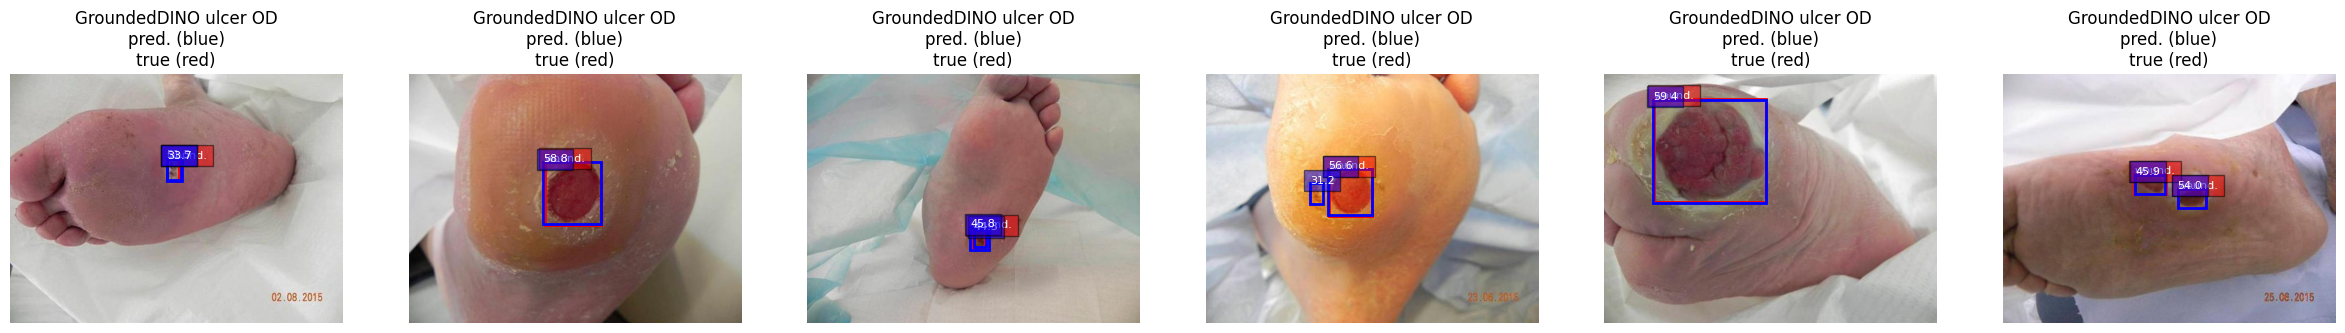

In [26]:
images, targets = next(dataiter) # get a batch
prompts = TEXT_PROMPT * images.shape[0]

with torch.no_grad():
    gd_model.eval()

    # forward GroundedDINO to get ulcer detection predictions
    gd_inputs = gd_processor(images=images, text=prompts, return_tensors="pt").to(device)
    
    with autocast(device_type='cuda', dtype=torch.float16):
        gd_outputs = gd_model(**gd_inputs, labels=move_to_device(targets, device), return_dict=True)
    
    gd_results = gd_processor.image_processor.post_process_object_detection(gd_outputs, threshold=0.3)

show_preds(images, targets, move_to_device(gd_results, "cpu"), n=6)